<a href="https://colab.research.google.com/github/charlie-aashutosh/Deep-Learning/blob/master/Encoders_Decoders_%26_Sequence_to_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mxnet

     |████████████████████████████████| 68.7MB 63kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
from mxnet.gluon import nn

#@save
class Encoder(nn.Block):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [4]:
#@save
class Decoder(nn.Block):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [5]:
#@save
class EncoderDecoder(nn.Block):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [7]:
!pip install d2l

     |████████████████████████████████| 61kB 3.6MB/s 


In [8]:
##Sequence to Sequence
from d2l import mxnet as d2l
from mxnet import np, npx, init, gluon, autograd
from mxnet.gluon import nn, rnn
npx.set_np()


In [14]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # `X` shape: (`batch_size`, `seq_len`, `embed_size`)
        X = self.embedding(X)
        # RNN needs first axes to be timestep, i.e., `seq_len`
        X = X.swapaxes(0, 1)
        state = self.rnn.begin_state(batch_size=X.shape[1], ctx=X.ctx)
        out, state = self.rnn(X, state)
        # `out` shape: (`seq_len`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`),
        # where "state" contains the hidden state and the memory cell
        return out, state

In [15]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.initialize()
X = np.zeros((4, 7))
output, state = encoder(X)
output.shape

(7, 4, 16)

In [16]:
len(state), state[0].shape, state[1].shape

(2, (2, 4, 16), (2, 4, 16))

In [17]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).swapaxes(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation
        out = self.dense(out).swapaxes(0, 1)
        return out, state

In [18]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
decoder.initialize()
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

((4, 7, 10), 2, (2, 4, 16), (2, 4, 16))

In [19]:
X = np.array([[1, 2, 3], [4, 5, 6]])
npx.sequence_mask(X, np.array([1, 2]), True, axis=1)

array([[1., 0., 0.],
       [4., 5., 0.]])

In [20]:
X = np.ones((2, 3, 4))
npx.sequence_mask(X, np.array([1, 2]), True, value=-1, axis=1)

array([[[ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.]]])

In [21]:

class MaskedSoftmaxCELoss(gluon.loss.SoftmaxCELoss):
    # `pred` shape: (`batch_size`, `seq_len`, `vocab_size`)
    # `label` shape: (`batch_size`, `seq_len`)
    # `valid_len` shape: (`batch_size`, )
    def forward(self, pred, label, valid_len):
        # weights shape: (batch_size, seq_len, 1)
        weights = np.expand_dims(np.ones_like(label), axis=-1)
        weights = npx.sequence_mask(weights, valid_len, True, axis=1)
        return super(MaskedSoftmaxCELoss, self).forward(pred, label, weights)

In [22]:
loss = MaskedSoftmaxCELoss()
loss(np.ones((3, 4, 10)), np.ones((3, 4)), np.array([4, 2, 0]))

array([2.3025851, 1.1512926, 0.       ])

In [23]:

def train_s2s_ch9(model, data_iter, lr, num_epochs, ctx):
    model.initialize(init.Xavier(), force_reinit=True, ctx=ctx)
    trainer = gluon.Trainer(model.collect_params(),
                            'adam', {'learning_rate': lr})
    loss = MaskedSoftmaxCELoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.as_in_ctx(ctx) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            with autograd.record():
                Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
                l = loss(Y_hat, Y_label, Y_vlen)
            l.backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            trainer.step(num_tokens)
            metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(ctx)}')

loss 0.026, 2436.3 tokens/sec on cpu(0)


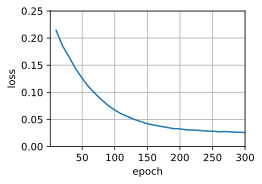

In [24]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 300, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

In [25]:

def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps,
                    ctx):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    enc_valid_len = np.array([len(src_tokens)], ctx=ctx)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = np.array(src_tokens, ctx=ctx)
    # Add the  batch size dimension
    enc_outputs = model.encoder(np.expand_dims(enc_X, axis=0),
                                enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = np.expand_dims(np.array([tgt_vocab['<bos>']], ctx=ctx), axis=0)
    predict_tokens = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next timestep input
        dec_X = Y.argmax(axis=2)
        py = dec_X.squeeze(axis=0).astype('int32').item()
        if py == tgt_vocab['<eos>']:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [27]:
##example
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

Go . => va !
Wow ! => <unk> !
I'm OK . => ça va .
I won ! => j'ai gagné !
